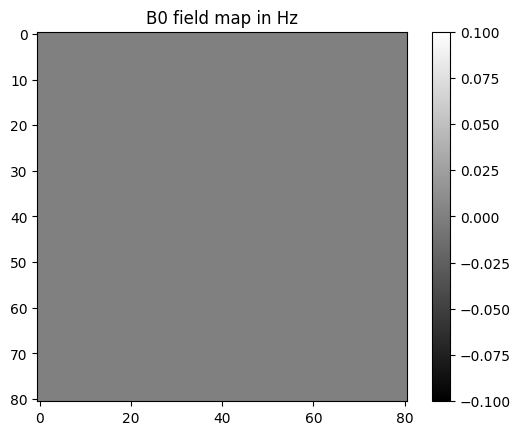

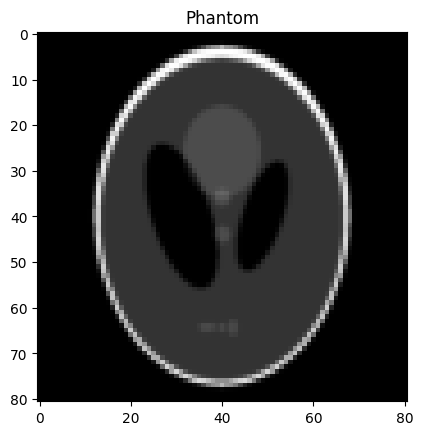

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (81, 81))
#phantom /= np.max(phantom)
phantom = phantom.astype(dtype=np.complex128) # Make the phantom complex


N_spins = 81  # Number of spins in the phantom
# # Phantom is a 2D delta function (single point in the center)
# phantom = np.zeros((N_spins, N_spins), dtype=np.complex128)  
# phantom[N_spins//2, N_spins//2] = 1

# Load the B0 field map from the csv file
B0_field_map = pd.read_csv('2Dslice.csv', header=None).values
gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
B0_field_map  = (B0_field_map * gamma)/(2*np.pi * 10000)  # Convert to Hz/T
B0_mean = np.mean(B0_field_map)  # Mean value of the B0 field map
B0_field_map -= np.mean(B0_field_map) # Dividing by the mean value of the B0 field map
B0_field_map *= 0
B0_field_map = resize(B0_field_map, (81, 81))

B0_test = np.ones((N_spins, N_spins), dtype=np.complex128)

B0_using = B0_field_map

# Plot the B0 field map
plt.title('B0 field map in Hz')
plt.imshow(B0_field_map, cmap='gray')
plt.colorbar()  # Add a color bar to the plot
plt.show()



# Plot the phantom
plt.title('Phantom')
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()



g_mult = 4 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
B0 = 1.0  # B0 field in T

81it [00:03, 26.37it/s]


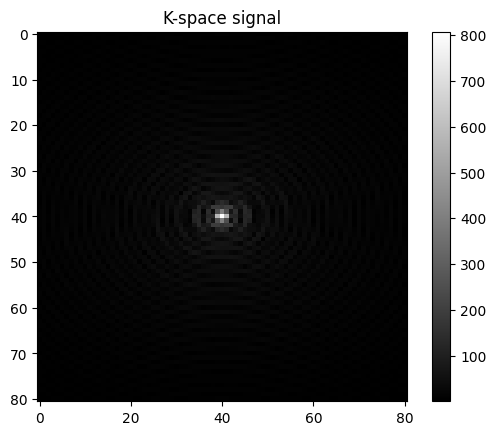

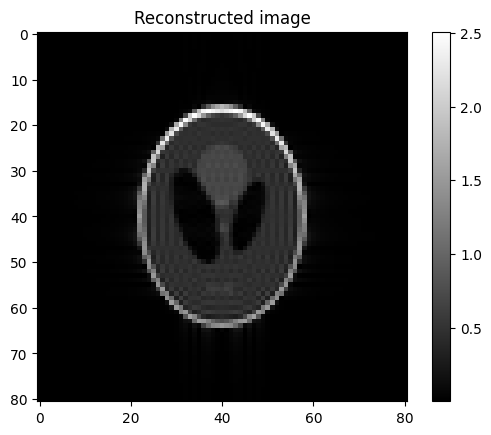

In [103]:
# Time intervals for the gradients
tau = 2e-3
time = np.linspace(-tau/2,tau/2,N_spins)

timey = np.linspace(-tau/2,tau/2,N_spins)

# B0 field inhomogeneities in the x and y directions

# Gradient fields (assuming same for x and y directions)
Gx_values = time * Gx
Gy_values = time * Gx

# k-space trajectory (assuming same for x and y directions)
kx_values = gamma * Gx_values 
ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')  # Create 2D coordinate grid


# Compute k-space values
k_space = np.zeros((N_spins, N_spins), dtype=np.complex128)
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        k_space[i, j] = np.sum(phantom * np.exp(-1j * (kx * x_values + ky * y_values)) * np.exp(-1j * 2 * np.pi * B0_using * time[j]))


#k_space = k_space * np.exp(-1j * 2 * np.pi * B0_field_map * time)

# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()

dwll_time = tau/N_spins

readout_bandwidth =  1/dwll_time


# Apply inverse FFT
reconstructed_image = ifft2(k_space)
reconstructed_image_1 = fftshift(reconstructed_image)

# Plot the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image_1), cmap='gray')
plt.title('Reconstructed image')
plt.colorbar()
plt.show()

In [104]:
x_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)


def inverse_fourier_2d(k_space):
    # Allocate a space for the output image
    image = np.zeros((N_spins, N_spins), dtype=np.complex128)

    # Create a grid of k-space indices
    i_values, j_values = np.meshgrid(np.arange(N_spins), np.arange(N_spins), indexing='ij')

    # Iterate through each pixel in k-space
    for m in tqdm(range(N_spins)):
        for n in range(N_spins):
            # Calculate the inverse Fourier transform using vectorized operations
            image[m, n] = np.sum(k_space * np.exp(1j * (kx_values[i_values] * x_values_1[m] + ky_values[j_values] * y_values_1[n])) * np.exp(-1j * 2 * np.pi * B0_using * time[n]))

    return image

# Apply the inverse Fourier transform to the k-space data
reconstructed_image = inverse_fourier_2d(k_space)

# # Plot the absolute value of the reconstructed image
# plt.figure()
# plt.imshow(np.abs(reconstructed_image), cmap='gray')
# plt.colorbar()
# plt.title('True Reconstructed Image')
# plt.show()


100%|██████████| 81/81 [00:03<00:00, 23.66it/s]


In [105]:
# Reshape the k-space data into a vector
kspace_vec = np.reshape(k_space, (N_spins*N_spins))

# Initialize a 2D encoding matrix
# encoding_matrix = np.zeros((N_spins**2, N_spins**2), dtype=np.complex128)

# # Iterate over each column in the k_space
# for i in tqdm(range(N_spins)):
#     for j in range(N_spins):  # Additional loop over columns
#         # Generate the 2D encoding matrix for this column
#         for k in range(N_spins):
#             for l in range(N_spins):
#                 # Subtract the phase due to B0 inhomogeneities
#                 phase_correction = 2 * np.pi * B0_field_map * time[j]
#                 Eij = np.exp(-1j * (kx_values[i] * x_values_1[k] + ky_values[j] * y_values_1[l])) * np.exp(-1j * phase_correction)
#                 # Flatten Eij and place it in the corresponding row of the large encoding matrix
#                 encoding_matrix[k*N_spins+l, i*N_spins+j] = Eij # Use i*N_spins+l to index the columns


# # Vectorized version of the encoding matrix. This is equivalent to the above code.
# # Generate 2D arrays for kx_values and ky_values
# kx_2d = kx_values[:, np.newaxis, np.newaxis, np.newaxis]
# ky_2d = ky_values[np.newaxis, :, np.newaxis, np.newaxis]

# # Generate 2D arrays for x_values_1 and y_values_1
# x_2d = x_values_1[np.newaxis, np.newaxis, :, np.newaxis]
# y_2d = y_values_1[np.newaxis, np.newaxis, np.newaxis, :]

# time_2d = time[np.newaxis, np.newaxis, np.newaxis, :]
# B0_field_map_2d = B0_field_map[np.newaxis, np.newaxis, :, :]

# # Compute the phase correction term
# phase_correction_2d = -2 * np.pi * B0_field_map_2d * time_2d

# # Compute Eij for all combinations of indices using broadcasting
# Eij_all = np.exp(-1j * (kx_2d * x_2d + ky_2d * y_2d) + 1j * phase_correction_2d)

# Flatten Eij_all to form the final encoding_matrix
# encoding_matrix = Eij_all.reshape(N_spins**2, N_spins**2)

In [106]:
# x, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(encoding_matrix, kspace_vec, iter_lim=200, show=True)
# image = np.reshape(x, (N_spins, N_spins))

In [107]:
# plt.figure()
# plt.imshow(np.abs(image), cmap='gray', vmin=0, vmax=1.0)
# plt.colorbar()
# plt.title('Reconstructed Image')
# plt.show()

In [108]:
E = np.zeros((N_spins**2, N_spins**2), dtype=np.complex128)

# Flatten the arrays to make them 1D
x_values_flat = x_values.flatten()
y_values_flat = y_values.flatten()
B0_field_map_flat = B0_using.flatten()

iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        # Use the flattened arrays in the calculation
        E[:, iterator] = np.exp(-1j * (kx * x_values_flat + ky * y_values_flat)) * np.exp(-1j * 2 * np.pi * B0_field_map_flat * time[j])
        iterator += 1

0it [00:00, ?it/s]

81it [00:04, 17.26it/s]


In [109]:
x_1, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(E, kspace_vec, iter_lim=200, show=True)
image_1 = np.reshape(x_1, (N_spins, N_spins))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 6561 rows and 6561 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.204e+03  2.204e+03    1.0e+00  5.6e-02
     1 6.94926e-05-2.01753e-16j   3.604e+01  3.604e+01    1.6e-02  5.9e-01   1.2e+02  1.0e+00
     2 2.26923e-04+7.55427e-17j   2.274e+01  2.274e+01    1.0e-02  2.4e-01   1.6e+02  2.1e+00
     3 8.19349e-04+6.89670e-16j   1.706e+01  1.706e+01    7.7e-03  3.2e-01   1.7e+02  3.9e+00
     4 1.66634e-03+8.87382e-16j   1.299e+01  1.299e+01    5.9e-03  2.4e-01   2.0e+02  5.8e+00
     5 1.19377e-03+9.93834e-16j   5.157e+00  5.157e+00    2.3e-03  2.7e-01   2.1e+02  8.5e+00
     6 6.67398e-04+1.04588e-15j   4.502e+00  4.502e+00    2.0e-03  4.1e-02   2.4e+02  1.0e+01
     7 -7.33709e-04+1.39774e-15j   4.382e+00

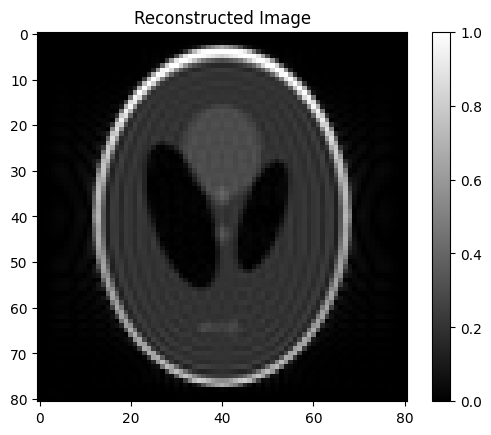

In [110]:
plt.figure()
plt.imshow(np.abs(image_1), cmap='gray', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()